In [1]:
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl



In [2]:
import esda
import pandas as pd
import geopandas as gpd
import seaborn as sns
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
from pylab import figure, scatter, show
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


# loading file 

In [3]:
#read london borough
boros = gpd.read_file('statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')

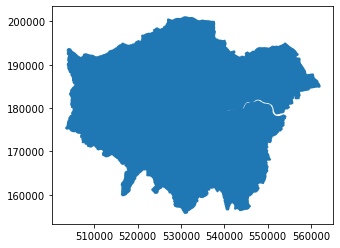

In [4]:
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})
# buffer the boundary by 250m
ldn['geometry'] = ldn.original.buffer(250)
ldn = ldn.set_geometry('geometry')
ldn.plot();

<AxesSubplot:>

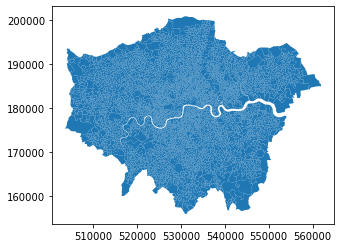

In [5]:
#lSOA Shapefile 
lsoas = gpd.read_file('statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp')
lsoas.plot()

In [6]:
green_acc = pd.read_csv("Data_firstclean/green_lsoa.csv",low_memory=False)

In [7]:
green_acc.head()

,lsoa11,blue_dist,green_pas,green_act
0,E01000001,2.387111,0.046221,0.295
1,E01000002,2.048814,0.041072,0.320
2,E01000003,1.217941,0.050611,0.200
3,E01000005,1.181282,0.044282,0.140
4,E01000006,1.760714,0.527459,0.585


In [8]:
lsoa_greenacc = pd.merge(lsoas, green_acc, left_on='LSOA11CD', right_on='lsoa11', how='left')
print(lsoa_greenacc.shape)
lsoa_greenacc

(4835, 19)


,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,lsoa11,blue_dist,green_pas,green_act
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,0,112.9,876,1.7,"POLYGON ((532105.092 182011.230, 532162.491 18...",E01000001,2.387111,0.046221,0.295
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,0,62.9,830,1.7,"POLYGON ((532746.813 181786.891, 532671.688 18...",E01000002,2.048814,0.041072,0.320
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,96,227.7,817,1.5,"POLYGON ((532135.145 182198.119, 532158.250 18...",E01000003,1.217941,0.050611,0.200
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,0,52.0,467,2.1,"POLYGON ((533807.946 180767.770, 533649.063 18...",E01000005,1.181282,0.044282,0.140
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,4,116.2,543,3.1,"POLYGON ((545122.049 184314.931, 545271.917 18...",E01000006,1.760714,0.527459,0.585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,E01033742,Greenwich 007F,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1352,1352,0,107.6,581,2.3,"POLYGON ((544642.680 179824.674, 544766.313 17...",E01033742,0.185333,0.039919,0.880
4831,E01033743,Greenwich 002H,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,2038,2038,0,20.4,663,3.1,"POLYGON ((546579.195 181097.813, 546687.036 18...",E01033743,0.634500,0.067162,0.955
4832,E01033744,Greenwich 007G,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1845,1728,117,125.8,646,2.7,"POLYGON ((544536.486 179447.115, 544602.630 17...",E01033744,0.273226,0.015671,0.600
4833,E01033745,Greenwich 002I,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,1820,1820,0,32.3,591,3.1,"POLYGON ((546415.745 180152.270, 546320.715 18...",E01033745,0.537037,0.104303,1.090


In [9]:
boro_green2 = lsoa_greenacc.groupby(['LAD11CD'],as_index=False)['blue_dist','green_act','green_pas'].median()
boro_green2.head()

,LAD11CD,blue_dist,green_act,green_pas
0,E09000001,1.199612,0.3075,0.045252
1,E09000002,1.324479,0.3800,0.706887
2,E09000003,3.113437,0.4400,0.611714
3,E09000004,2.064403,0.4775,0.363154
4,E09000005,2.081429,0.3800,0.470558


In [10]:
#add green space with borough file
boro_greenacc = pd.merge(boros, boro_green2, left_on='GSS_CODE', right_on='LAD11CD', how='left')
print(boro_greenacc.shape)
boro_greenacc.head()

(33, 12)


,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,LAD11CD,blue_dist,green_act,green_pas
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16...",E09000021,3.443026,0.51207,0.464815
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15...",E09000008,2.908372,0.50500,0.584036
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",E09000006,2.637000,0.47000,0.478473
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17...",E09000018,1.598901,0.38250,0.564246
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18...",E09000009,2.013571,0.37750,0.553855


In [11]:
other = pd.read_csv("Data_firstclean/other_factors2.csv",low_memory=False)
other.head()

,Area_code,Area_name,obesity(age18+),respiratory,coronary,TB_incidence,Active,Females,Populationdensity,housingprice,...,65+(100%),All_persons,total_cases,ln_total_cases,total_cases2,covid0_60,covid_60up,total_case_rate,infection_tate(60-),infection_tate(60+)
0,E09000002,Barking and Dagenham,64.5155,133.0534,104.4367,20.6100,0.519,0.513476,6064.0,300000.0,...,0.086798,218900,71600,11.178850,27327,65036.0,6633.0,32.708999,34.050262,24.032533
1,E09000003,Barnet,61.1233,77.4378,88.5450,13.3525,0.616,0.516054,4487.0,533500.0,...,0.144105,389300,132459,11.794028,51285,115297.0,17370.0,34.024917,36.707100,23.098360
2,E09000004,Bexley,64.6095,88.3333,90.9369,8.8988,0.524,0.519270,4069.0,342500.0,...,0.166329,246500,85071,11.351241,35010,72806.0,12377.0,34.511562,37.939552,22.668429
3,E09000005,Brent,55.8951,72.4171,103.4684,32.5362,0.557,0.509417,7859.0,499950.0,...,0.116245,339800,106510,11.575994,40930,93742.0,12837.0,31.344909,33.019373,22.964174
4,E09000006,Bromley,58.0292,83.4814,80.1178,5.2376,0.683,0.520303,2198.0,440000.0,...,0.176667,330000,114402,11.647474,47084,98314.0,16263.0,34.667273,38.782643,21.231022


In [12]:
#add green space with borough file
boro_xy = pd.merge(boro_greenacc,other, left_on="GSS_CODE", right_on='Area_code', how='inner')
boro_xy.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,LAD11CD,blue_dist,...,65+(100%),All_persons,total_cases,ln_total_cases,total_cases2,covid0_60,covid_60up,total_case_rate,infection_tate(60-),infection_tate(60+)
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16...",E09000021,3.443026,...,0.144048,168000,63134,11.053015,25388,55474.0,7745.0,37.579762,40.910030,23.904215
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15...",E09000008,2.908372,...,0.135875,390800,130320,11.777748,54280,113581.0,16970.0,33.346981,35.796092,23.119848
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",E09000006,2.637000,...,0.176667,330000,114402,11.647474,47084,98314.0,16263.0,34.667273,38.782643,21.231022
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17...",E09000018,1.598901,...,0.117974,288200,98773,11.500580,37581,87660.0,11146.0,34.272380,36.373444,23.564423
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18...",E09000009,2.013571,...,0.121220,367100,124575,11.732663,47256,109930.0,14669.0,33.934895,36.054444,23.621532


In [13]:
boro_xy.drop(["GSS_CODE","HECTARES","NONLD_AREA","ONS_INNER"],axis=1, inplace=True)

In [14]:
boro_xy=boro_xy.set_index("Area_code", drop=True, append=False, inplace=False, verify_integrity=False)
boro_xy.head()

,NAME,SUB_2009,SUB_2006,geometry,LAD11CD,blue_dist,green_act,green_pas,Area_name,obesity(age18+),...,65+(100%),All_persons,total_cases,ln_total_cases,total_cases2,covid0_60,covid_60up,total_case_rate,infection_tate(60-),infection_tate(60+)
Area_code,,,,,,,,,,,,,,,,,,,,,
E09000021,Kingston upon Thames,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16...",E09000021,3.443026,0.51207,0.464815,Kingston upon Thames,57.6050,...,0.144048,168000,63134,11.053015,25388,55474.0,7745.0,37.579762,40.910030,23.904215
E09000008,Croydon,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15...",E09000008,2.908372,0.50500,0.584036,Croydon,61.8092,...,0.135875,390800,130320,11.777748,54280,113581.0,16970.0,33.346981,35.796092,23.119848
E09000006,Bromley,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",E09000006,2.637000,0.47000,0.478473,Bromley,58.0292,...,0.176667,330000,114402,11.647474,47084,98314.0,16263.0,34.667273,38.782643,21.231022
E09000018,Hounslow,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17...",E09000018,1.598901,0.38250,0.564246,Hounslow,63.2337,...,0.117974,288200,98773,11.500580,37581,87660.0,11146.0,34.272380,36.373444,23.564423
E09000009,Ealing,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18...",E09000009,2.013571,0.37750,0.553855,Ealing,53.0091,...,0.121220,367100,124575,11.732663,47256,109930.0,14669.0,33.934895,36.054444,23.621532


In [15]:
boro_xy.drop(["LAD11CD","Area_name"],axis=1, inplace=True)

In [16]:
boro_xy.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 32 entries, E09000021 to E09000002
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   NAME                 32 non-null     object  
 1   SUB_2009             0 non-null      object  
 2   SUB_2006             0 non-null      object  
 3   geometry             32 non-null     geometry
 4   blue_dist            32 non-null     float64 
 5   green_act            32 non-null     float64 
 6   green_pas            32 non-null     float64 
 7   obesity(age18+)      32 non-null     float64 
 8   respiratory          32 non-null     float64 
 9   coronary             32 non-null     float64 
 10  TB_incidence         32 non-null     float64 
 11  Active               32 non-null     float64 
 12  Females              32 non-null     float64 
 13  Populationdensity    32 non-null     float64 
 14  housingprice         32 non-null     float64 
 15  income 

In [17]:
# GWR

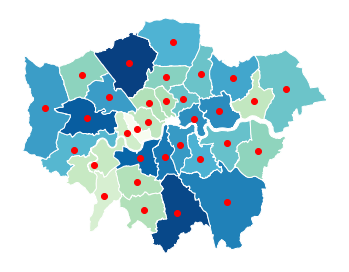

In [18]:
ax = boro_xy.plot(edgecolor='white',column="total_cases",cmap='GnBu',figsize=(6,6))
boro_xy.centroid.plot(ax=ax, color='r',marker='o')
ax.set_axis_off()

In [19]:
boro_xy['centro']=boro_xy.centroid
boro_xy['X']=boro_xy.centro.x
boro_xy['Y']=boro_xy.centro.y
coords = list(zip(boro_xy['X'],boro_xy['Y']))

In [20]:
coords[0:5]

[(519297.6348074289, 166820.01149016235),
 (533290.1539193918, 163541.24357427526),
 (542895.5116070557, 165655.52134038546),
 (513515.5055361106, 175643.2243196642),
 (515887.9377702068, 181715.49561692882)]

In [21]:
boro_xy.head()

,NAME,SUB_2009,SUB_2006,geometry,blue_dist,green_act,green_pas,obesity(age18+),respiratory,coronary,...,ln_total_cases,total_cases2,covid0_60,covid_60up,total_case_rate,infection_tate(60-),infection_tate(60+),centro,X,Y
Area_code,,,,,,,,,,,,,,,,,,,,,
E09000021,Kingston upon Thames,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16...",3.443026,0.51207,0.464815,57.6050,83.2563,89.3540,...,11.053015,25388,55474.0,7745.0,37.579762,40.910030,23.904215,POINT (519297.635 166820.011),519297.634807,166820.011490
E09000008,Croydon,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15...",2.908372,0.50500,0.584036,61.8092,96.4060,88.0417,...,11.777748,54280,113581.0,16970.0,33.346981,35.796092,23.119848,POINT (533290.154 163541.244),533290.153919,163541.243574
E09000006,Bromley,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",2.637000,0.47000,0.478473,58.0292,83.4814,80.1178,...,11.647474,47084,98314.0,16263.0,34.667273,38.782643,21.231022,POINT (542895.512 165655.521),542895.511607,165655.521340
E09000018,Hounslow,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17...",1.598901,0.38250,0.564246,63.2337,95.9538,115.7913,...,11.500580,37581,87660.0,11146.0,34.272380,36.373444,23.564423,POINT (513515.506 175643.224),513515.505536,175643.224320
E09000009,Ealing,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18...",2.013571,0.37750,0.553855,53.0091,89.0166,97.2686,...,11.732663,47256,109930.0,14669.0,33.934895,36.054444,23.621532,POINT (515887.938 181715.496),515887.937770,181715.495617


In [22]:
###  model1 :total case reate 

In [23]:
g_y = boro_xy['infection_tate(60+)'].values
 
# 自变量
g_X = boro_xy[['blue_dist','green_act','obesity(age18+)','respiratory','coronary',"TB_incidence","Active","Females","income"]].values
 
"""# 坐标信息Latitude	Longitud
u = georgia_data['Longitud']
v = georgia_data['Latitude']
g_coords = list(zip(u,v))"""
 
# z标准化
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
g_y = g_y.reshape((-1,1))
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [24]:
g_X.shape

(32, 9)

In [25]:
g_y.shape

(32, 1)

In [26]:
gwr_selector = Sel_BW(coords, g_y, g_X,fixed=True,kernel='gaussian')
gwr_bw = gwr_selector.search(criterion='AICc')
gwr_results = GWR(coords, g_y, g_X,gwr_bw,fixed=True,kernel='gaussian').fit()

In [27]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                  32
Number of covariates:                                                    10

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             15.264
Log-likelihood:                                                     -33.563
AIC:                                                                 87.125
AICc:                                                               102.325
BIC:                                                                -60.982
R2:                                                                   0.523
Adj. R2:                                                              0.328

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [28]:
boro_xy['gwr_x0'] = gwr_results.params[:,0]0.003

boro_xy['gwr_x1'] = gwr_results.params[:,1]
boro_xy['gwr_x2'] = gwr_results.params[:,2]
boro_xy['gwr_x3'] = gwr_results.params[:,3]
boro_xy['gwr_x4'] = gwr_results.params[:,4]
boro_xy['gwr_x5'] = gwr_results.params[:,5]
boro_xy['gwr_x6'] = gwr_results.params[:,6]
boro_xy['gwr_x7'] = gwr_results.params[:,7]
boro_xy['gwr_x8'] = gwr_results.params[:,8]
boro_xy['gwr_x9'] = gwr_results.params[:,9]

IndexError: list index out of range

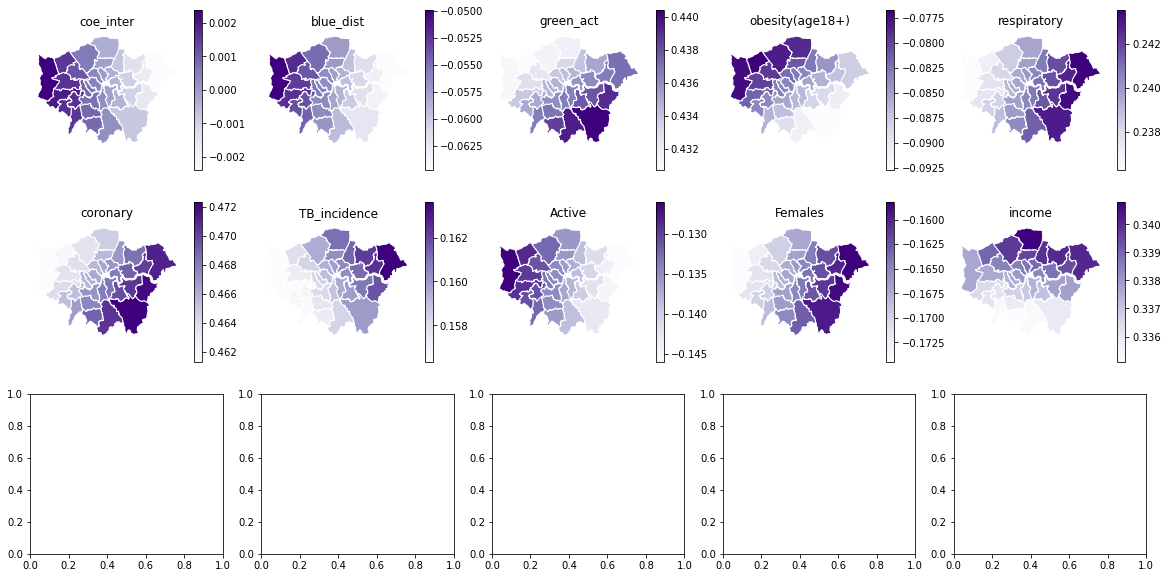

In [31]:
fig,ax = plt.subplots(nrows=3, ncols=5,figsize=(20,10))
axes = ax.flatten()
var_names =["coe_inter",'blue_dist','green_act','obesity(age18+)','respiratory','coronary',"TB_incidence","Active","Females","income"]
var_names1 = ['gwr_x0','gwr_x1','gwr_x2','gwr_x3','gwr_x4','gwr_x5','gwr_x6','gwr_x7','gwr_x8','gwr_x9']

for i in range(0,len(axes)-1):
    
    ax=axes[i]
    ax.set_title(var_names[i])
    boro_xy.plot(ax=ax,column=var_names1[i],edgecolor='white',cmap='Purples',legend=True)
    
    #if (gwr_flter_t[i] == 0).any():
     #   boro_xy[gwr_flter_t[i] == 0].plot(color='lightgrey', ax=ax, edgecolor='white') # 灰色部分表示该系数不显著
 
    
    ax.set_axis_off()
    if i+1==7:
        axes[7].axis('off')
        
plt.show()
plt.savefig(os.path.join('img','GWR 60+.png'))